In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
import ufs2arco.utils as uu

In [3]:
ads = xr.open_zarr("/pscratch/sd/t/timothys/anemoi-house/replay/atmosphere-subsampled/p1/training.zarr")
mds = xr.open_zarr("/pscratch/sd/t/timothys/p2p/cnuvwc/old-normalization/mean_by_level.zarr")
sds = xr.open_zarr("/pscratch/sd/t/timothys/p2p/cnuvwc/old-normalization/stddev_by_level.zarr")
dsds = xr.open_zarr("/pscratch/sd/t/timothys/p2p/cnuvwc/old-normalization/diffs_stddev_by_level.zarr")

In [4]:
gefs = xr.open_zarr("/pscratch/sd/t/timothys/gefs/one-degree/forecasts.zarr", decode_timedelta=True)

In [5]:
xx = xr.open_zarr("/pscratch/sd/t/timothys/p2p/cnuvwc/training/inputs.zarr")

### Verify progress

In [6]:
def year_progress(xds: xr.Dataset, time="time"):

    seconds_since_epoch = xds[time].astype("datetime64[s]").astype(np.int64)
    seconds_per_day = 3600 * 24
    avg_days_per_year = np.float64(365.24219)
    denominator = seconds_per_day * avg_days_per_year
    years_since_epoch = seconds_since_epoch / denominator
    return np.mod(years_since_epoch, 1.0).astype(np.float32)

In [7]:
def day_progress(xds: xr.Dataset, time="time"):

    seconds_since_epoch = xds[time].astype("datetime64[s]").astype(np.int64)
    seconds_per_day = 3600 * 24
    day_progress_greenwich = np.mod(seconds_since_epoch, seconds_per_day) / seconds_per_day

    longitude_offsets = np.deg2rad(xds["longitude"]) / 2 / np.pi
    day_progress = np.mod(day_progress_greenwich + longitude_offsets, 1.0)
    return day_progress.astype(np.float32)

In [8]:
yp = year_progress(ads, time="dates")
dp = day_progress(gefs, time="t0")

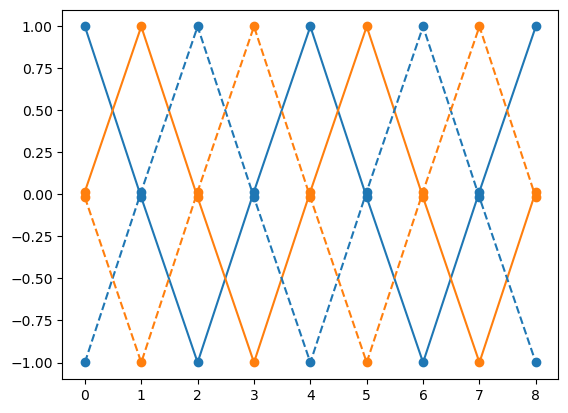

In [9]:
plt.plot(np.cos(dp.sel(longitude=.5, method="nearest")*2*np.pi)[:9], marker="o")
plt.plot(np.sin(dp.sel(longitude=.5, method="nearest")*2*np.pi)[:9], marker="o")

plt.plot(np.cos(dp.sel(longitude=180.5, method="nearest")*2*np.pi)[:9], marker="o", color="C0", linestyle="--")
plt.plot(np.sin(dp.sel(longitude=180.5, method="nearest")*2*np.pi)[:9], marker="o", color="C1", linestyle="--")

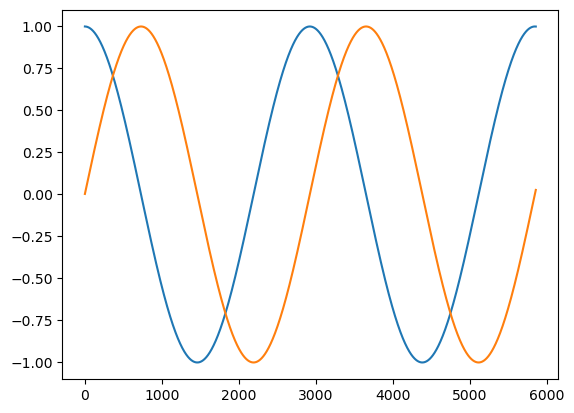

In [10]:
plt.plot(np.cos(yp.values*2*np.pi)[:366*8*2])
plt.plot(np.sin(yp.values*2*np.pi)[:366*8*2])

### Compare normalization

In [11]:
mds = mds.rename({"spfh": "log_spfh", "spfh2m": "log_spfh2m"})
sds = sds.rename({"spfh": "log_spfh", "spfh2m": "log_spfh2m"})
dsds = dsds.rename({"spfh": "log_spfh", "spfh2m": "log_spfh2m"})

In [12]:
from collections import defaultdict
def expand_anemoi_to_dataset(xda: xr.DataArray, variable_names: list[str]) -> xr.Dataset:
    """
    Converts a DataArray with dimensions [time, variable, cell] into an xarray.Dataset
    where each variable has dimensions [time, cell].

    Parameters:
        xda (xr.DataArray): The input data array with dimensions [time, variable, cell].
        variable_names (list[str]): A list of variable names corresponding to the 'variable' dimension.

    Returns:
        xr.Dataset: A dataset with each variable as a [time, cell] DataArray.
    """
    if xda.sizes['variable'] != len(variable_names):
        raise ValueError("Length of variable_names does not match the size of the 'variable' dimension.")

    # Use regex to detect base name and level
    level_groups = defaultdict(list)
    flat_vars = []

    for name in variable_names:
        parts = name.rsplit("_", 1)
        if len(parts) > 1 and parts[-1].isdigit():
            base = parts[0]
            level = int(parts[-1])
            level_groups[base].append((level, name))
        else:
            flat_vars.append(name)

    dsdict = {}

    # Add grouped variables with levels
    for base, level_name_pairs in level_groups.items():

        dalist = []
        for level, level_name in level_name_pairs:
            this_2d_array = xda.sel(variable=variable_names.index(level_name))
            this_2d_array = this_2d_array.drop_vars("variable")
            this_2d_array = this_2d_array.expand_dims({"level": [level]})
            dalist.append(this_2d_array)

        dsdict[base] = xr.concat(dalist, dim="level")

    # Add flat variables
    for name in flat_vars:
        dsdict[name] = xda.sel(variable=variable_names.index(name)).drop_vars("variable")

    xds = xr.Dataset({k: dsdict[k] for k in sorted(dsdict)})
    for key in xds.data_vars:
        dims = tuple(d for d in ("time", "ensemble", "level", "cell") if d in xds[key].dims)
        xds[key] = xds[key].transpose(*dims)
    return xds

In [13]:
amds = expand_anemoi_to_dataset(ads["mean"], ads.attrs["variables"])
asds = expand_anemoi_to_dataset(ads["stdev"], ads.attrs["variables"])
adsds = expand_anemoi_to_dataset(ads["residual_stdev"], ads.attrs["variables"])

In [15]:
rename = {
    "cos_day_progress": "day_progress_cos", 
    "sin_day_progress": "day_progress_sin", 
    "cos_year_progress": "year_progress_cos", 
    "sin_year_progress": "year_progress_sin", 
}
amds = amds.rename(rename)
asds = asds.rename(rename)
adsds = adsds.rename(rename)

In [16]:
for key in mds.data_vars:
    if key not in amds:
        print(key)

In [56]:
for key in ["day_progress_cos", "day_progress_sin", "year_progress_cos", "year_progress_sin"]:
    print(f"Old, Anemoi: {mds[key].values}, {amds[key].values}")


Old, Anemoi: 3.973590523287385e-08, 3.3527612686157227e-08
Old, Anemoi: 0.0, -2.483526865641276e-09
Old, Anemoi: -4.9160735215991735e-06, -3.124369744615191e-05
Old, Anemoi: 1.8478459651305457e-08, 1.4598648662342865e-08


/tmp/ipykernel_2119333/2015376038.py:10: RuntimeWarning: divide by zero encountered in divide
  values = np.array([axds[varname].values / xds[varname].values for varname in varnames])


min, max, mean: -inf, 6.355417043475887, -inf
min, max, mean: 0.9999908861532363, 4.909856710817614, 2.182817453595562
min, max, mean: 0.9999899638646697, 5.460069310530725, 2.0786904373176305


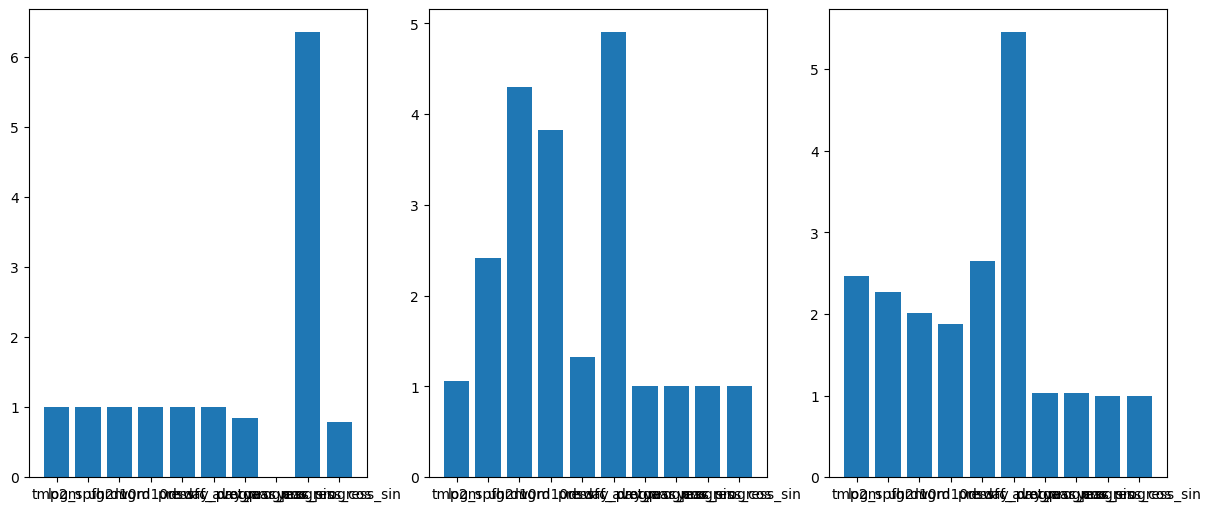

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(12,5), constrained_layout=True)

varnames = ["tmp2m", "log_spfh2m", "ugrd10m", "vgrd10m", "pressfc", "dswrf_avetoa", "day_progress_cos", "day_progress_sin", "year_progress_cos", "year_progress_sin"]

for xds, axds, ax in zip(
    [mds, sds, dsds],
    [amds, asds, adsds],
    axs,
):
    values = np.array([axds[varname].values / xds[varname].values for varname in varnames])
    ax.bar(varnames, values)
    print(f"min, max, mean: {values.min()}, {values.max()}, {values.mean()}")

min, max, mean: 0.9998658013903085, 0.9999991987925173, 0.9999352746654655
min, max, mean: 1.000001272233256, 1.0000051253127111, 1.000002115310837
min, max, mean: 1.0000007975685663, 1.0000025370744354, 1.0000012471217603


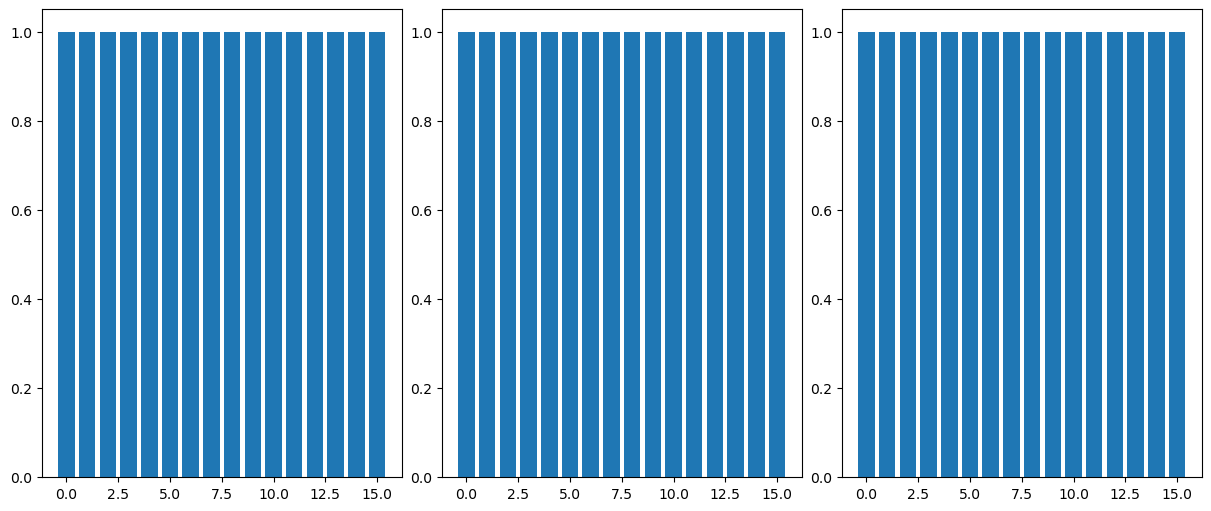

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12,5), constrained_layout=True)

varname = "dzdt"

for xds, axds, ax in zip(
    [mds, sds, dsds],
    [amds, asds, adsds],
    axs,
):
    values = axds[varname].values / xds[varname].values
    ax.bar(np.arange(16), values)
    print(f"min, max, mean: {values.min()}, {values.max()}, {values.mean()}")

In [38]:
axds.level.values

array([225, 275, 325, 375, 425, 475, 525, 575, 625, 675, 725, 775, 825,
       875, 925, 975])

min, max, mean: 0.9999999637533454, 1.0, 0.9999999818766727
min, max, mean: 1.0, 1.00008752714669, 1.000043763573345


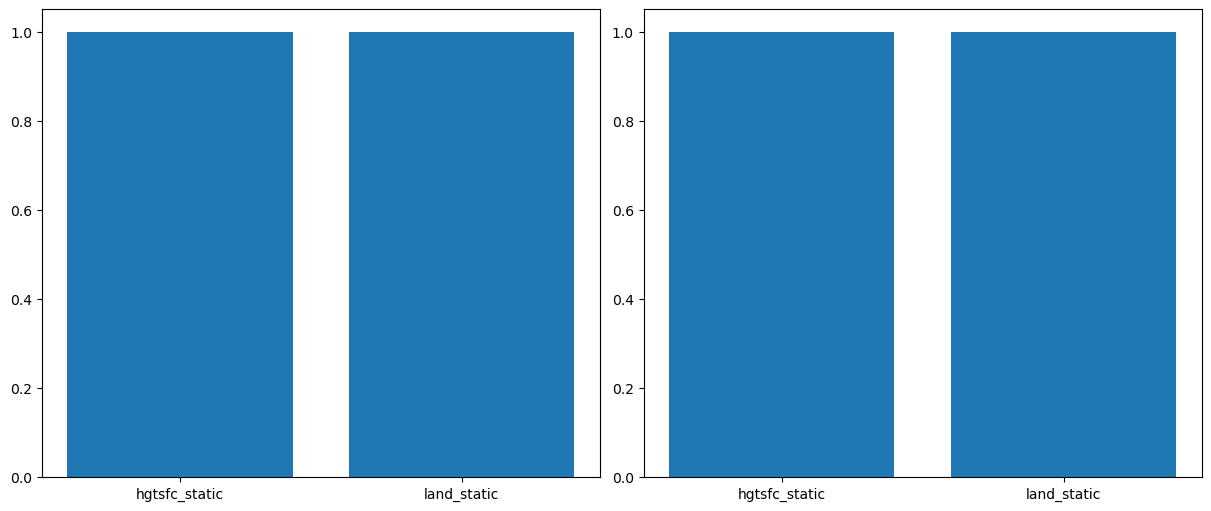

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

varnames = ["hgtsfc_static", "land_static"]

for xds, axds, ax in zip(
    [mds, sds, dsds],
    [amds, asds, adsds],
    axs,
):
    values = np.array([axds[varname].values / xds[varname].values for varname in varnames])
    ax.bar(varnames, values)
    print(f"min, max, mean: {values.min()}, {values.max()}, {values.mean()}")

In [71]:
swish = lambda x: x / (1 + np.exp(-x))

In [102]:
normalized_data = np.random.normal(size=(100))

In [107]:
normalize = lambda x: (x - x.mean()) / x.std()

In [122]:
key = "log_spfh2m"
factor = 2.5

idx = ads.attrs["variables"].index(key)
field = ads["data"].sel(time=0, variable=idx).squeeze().values.flatten()
normalized_field = (field - ads["mean"].sel(variable=idx).values)/ads["stdev"].sel(variable=idx).values

In [127]:
key = "tmp2m"
factor = 2

idx = ads.attrs["variables"].index(key)
field = ads["data"].diff("time").sel(time=10, variable=idx).squeeze().values.flatten()
normalized_field = field/ads["residual_stdev"].sel(variable=idx).values

In [128]:
normalied_data = normalized_field

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0., 36581.,
        11617.,  5716.,  4126.,  3541.,  2922.,  2240.,  1773.,  1299.,
         1018.,   873.,   540.]),
 array([-3.        , -2.68421053, -2.36842105, -2.05263158, -1.73684211,
        -1.42105263, -1.10526316, -0.78947368, -0.47368421, -0.15789474,
         0.15789474,  0.47368421,  0.78947368,  1.10526316,  1.42105263,
         1.73684211,  2.05263158,  2.36842105,  2.68421053,  3.        ]),
 <BarContainer object of 19 artists>)

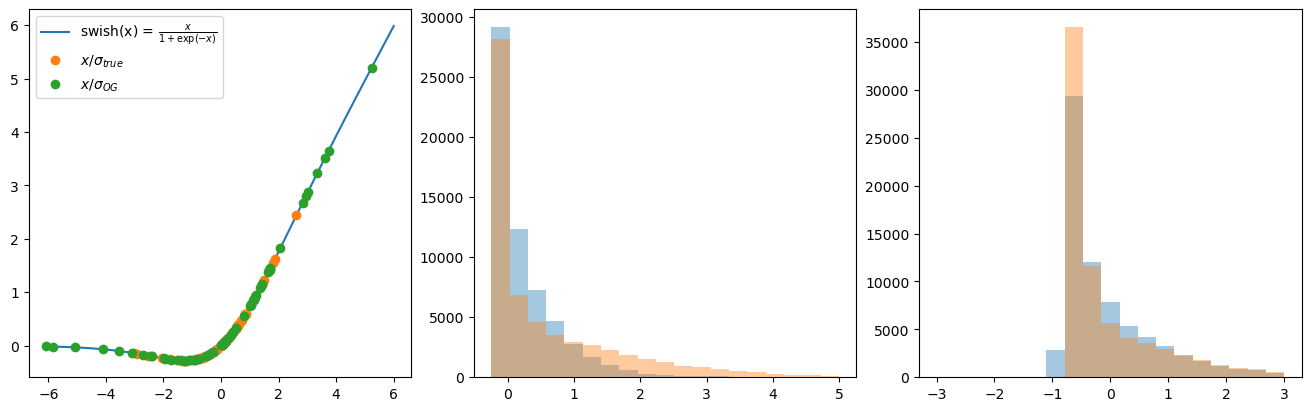

In [131]:
fig, axs = plt.subplots(1, 3, figsize=(13,4), constrained_layout=True)

skip = 1000
og_data = factor * normalized_data

ax=axs[0]
xvals = np.linspace(-6,6, 100)
ax.plot(xvals, swish(xvals), label=r"swish(x) = $\frac{x}{1+\exp(-x)}$")
ax.plot(normalized_data[::skip], swish(normalized_data[::skip]), marker="o", ls="", label=r"$x / \sigma_{true}$")
ax.plot(og_data[::skip], swish(og_data[::skip]), marker="o", ls="", label=r"$x / \sigma_{OG}$")

ax.legend()

ax=axs[1]
bins = np.linspace(-.25, 5, 20)
ax.hist(swish(normalized_data), bins=bins, alpha=.4)
ax.hist(swish(og_data), bins=bins, alpha=.4)

ax=axs[2]
bins = np.linspace(-3,3,20)
ax.hist(normalize(swish(normalized_data)), bins=bins, alpha=.4)
ax.hist(normalize(swish(og_data)), bins=bins, alpha=.4)

### Store the new ones

In [48]:
for old, new, prefix in zip(
    [mds, sds, dsds],
    [amds, asds, adsds],
    ["mean", "stddev", "diffs_stddev"],
):
    xds = new.copy()
    xds["new_level"] = xr.DataArray(
        old["level"].values,
        coords=xds.level.coords,
        attrs=old.level.attrs.copy(),
    )
    xds = xds.set_coords("new_level")
    xds = xds.rename({"level": "old_level"}).rename({"new_level": "level"})
    xds = xds.swap_dims({"old_level": "level"})
    xds = xds.drop_vars("old_level")
    print(xds)
    for key in xds.data_vars:
        if key in old:
            if "level" in xds[key].dims:
                xds[key] = xds[key].chunk({"level": -1})
            xds[key].attrs = old[key].attrs.copy()
            xds[key].encoding = {}
        else:
            xds = xds.drop_vars(key)

    xds = xds.rename({"log_spfh": "spfh", "log_spfh2m": "spfh2m"})

    xds.to_zarr(f"/pscratch/sd/t/timothys/p2p/cnuvwc/normalization/{prefix}_by_level.zarr")

<xarray.Dataset> Size: 864B
Dimensions:            (level: 16)
Coordinates:
  * level              (level) float64 128B 226.1 277.8 327.7 ... 922.6 974.3
Data variables: (12/17)
    day_progress_cos   float64 8B dask.array<chunksize=(), meta=np.ndarray>
    year_progress_cos  float64 8B dask.array<chunksize=(), meta=np.ndarray>
    dswrf_avetoa       float64 8B dask.array<chunksize=(), meta=np.ndarray>
    dzdt               (level) float64 128B dask.array<chunksize=(1,), meta=np.ndarray>
    hgtsfc_static      float64 8B dask.array<chunksize=(), meta=np.ndarray>
    land_static        float64 8B dask.array<chunksize=(), meta=np.ndarray>
    ...                 ...
    tmp                (level) float64 128B dask.array<chunksize=(1,), meta=np.ndarray>
    tmp2m              float64 8B dask.array<chunksize=(), meta=np.ndarray>
    ugrd               (level) float64 128B dask.array<chunksize=(1,), meta=np.ndarray>
    ugrd10m            float64 8B dask.array<chunksize=(), meta=np.ndarray

In [49]:
xyz = xr.open_zarr("/pscratch/sd/t/timothys/p2p/cnuvwc/normalization/mean_by_level.zarr")

In [50]:
xyz

<xarray.Dataset> Size: 864B
Dimensions:            (level: 16)
Coordinates:
  * level              (level) float64 128B 226.1 277.8 327.7 ... 922.6 974.3
Data variables: (12/17)
    day_progress_cos   float64 8B ...
    day_progress_sin   float64 8B ...
    dswrf_avetoa       float64 8B ...
    dzdt               (level) float64 128B dask.array<chunksize=(16,), meta=np.ndarray>
    hgtsfc_static      float64 8B ...
    land_static        float64 8B ...
    ...                 ...
    ugrd               (level) float64 128B dask.array<chunksize=(16,), meta=np.ndarray>
    ugrd10m            float64 8B ...
    vgrd               (level) float64 128B dask.array<chunksize=(16,), meta=np.ndarray>
    vgrd10m            float64 8B ...
    year_progress_cos  float64 8B ...
    year_progress_sin  float64 8B ...

In [51]:
mds

<xarray.Dataset> Size: 500B
Dimensions:            (level: 16)
Coordinates:
  * level              (level) float64 128B 226.1 277.8 327.7 ... 922.6 974.3
Data variables: (12/17)
    day_progress_cos   float32 4B ...
    day_progress_sin   float32 4B ...
    dswrf_avetoa       float32 4B ...
    dzdt               (level) float32 64B dask.array<chunksize=(16,), meta=np.ndarray>
    hgtsfc_static      float32 4B ...
    land_static        float64 8B ...
    ...                 ...
    ugrd               (level) float32 64B dask.array<chunksize=(16,), meta=np.ndarray>
    ugrd10m            float32 4B ...
    vgrd               (level) float32 64B dask.array<chunksize=(16,), meta=np.ndarray>
    vgrd10m            float32 4B ...
    year_progress_cos  float32 4B ...
    year_progress_sin  float32 4B ...

In [32]:
mds["log_spfh"]

<xarray.DataArray 'log_spfh' (level: 16)> Size: 64B
dask.array<open_dataset-spfh, shape=(16,), dtype=float32, chunksize=(16,), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) float64 128B 226.1 277.8 327.7 373.8 ... 874.7 922.6 974.3
Attributes:
    cell_methods:               time: point
    description:                average over ['time', 'grid_yt', 'grid_xt']
    long_name:                  log of specific humidity
    max_abs_compression_error:  6.686896085739136e-07
    nbits:                      14
    output_file:                dyn
    regridding:                 delz weighted average in vertical, new coordi...
    stats_end_date:             2019-12-31T18
    stats_start_date:           1993-12-31T18
    transformation:             this variable shows log(spfh)
    units:

In [33]:
amds["log_spfh"]

<xarray.DataArray 'log_spfh' (level: 16)> Size: 128B
dask.array<concatenate, shape=(16,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) int64 128B 225 275 325 375 425 475 ... 775 825 875 925 975

In [ ]:
asds

In [23]:
sds

<xarray.Dataset> Size: 544B
Dimensions:            (level: 16)
Coordinates:
  * level              (level) float64 128B 226.1 277.8 327.7 ... 922.6 974.3
Data variables: (12/17)
    day_progress_cos   float64 8B ...
    day_progress_sin   float64 8B ...
    dswrf_avetoa       float64 8B ...
    dzdt               (level) float32 64B dask.array<chunksize=(16,), meta=np.ndarray>
    hgtsfc_static      float64 8B ...
    land_static        float64 8B ...
    ...                 ...
    ugrd               (level) float32 64B dask.array<chunksize=(16,), meta=np.ndarray>
    ugrd10m            float64 8B ...
    vgrd               (level) float32 64B dask.array<chunksize=(16,), meta=np.ndarray>
    vgrd10m            float64 8B ...
    year_progress_cos  float64 8B ...
    year_progress_sin  float64 8B ...

In [22]:
key = "ugrd10m"
adsds[key].values / dsds[key].values

np.float64(2.0144184373303395)

In [49]:
ds = xr.open_zarr("gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr", storage_options={"token": "anon"}, decode_timedelta=True)


In [57]:
sample = expand_anemoi_to_dataset(ads["data"].isel(time=slice(10)), variable_names=ads.attrs["variables"])

In [54]:
sw = ds.dswrf_avetoa.isel(time=slice(10)).load();

ERROR! Session/line number was not unique in database. History logging moved to new session 492


In [60]:
sample["insolation"].squeeze().reshape(sw.shape).plot(col="time", col_wrap=5)

AttributeError: 'DataArray' object has no attribute 'reshape'

In [61]:
insolation = sample["insolation"].squeeze()

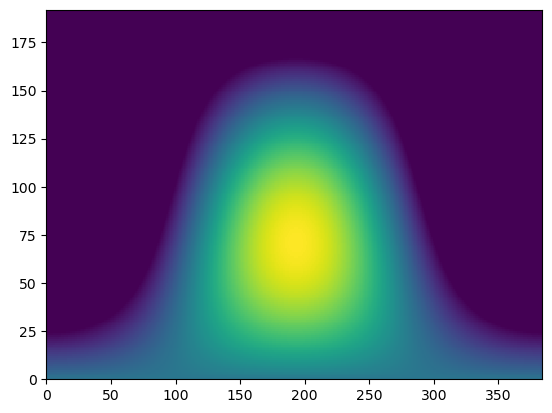

In [65]:
plt.pcolormesh(insolation.values.reshape(sw.shape)[0,::-1,:])

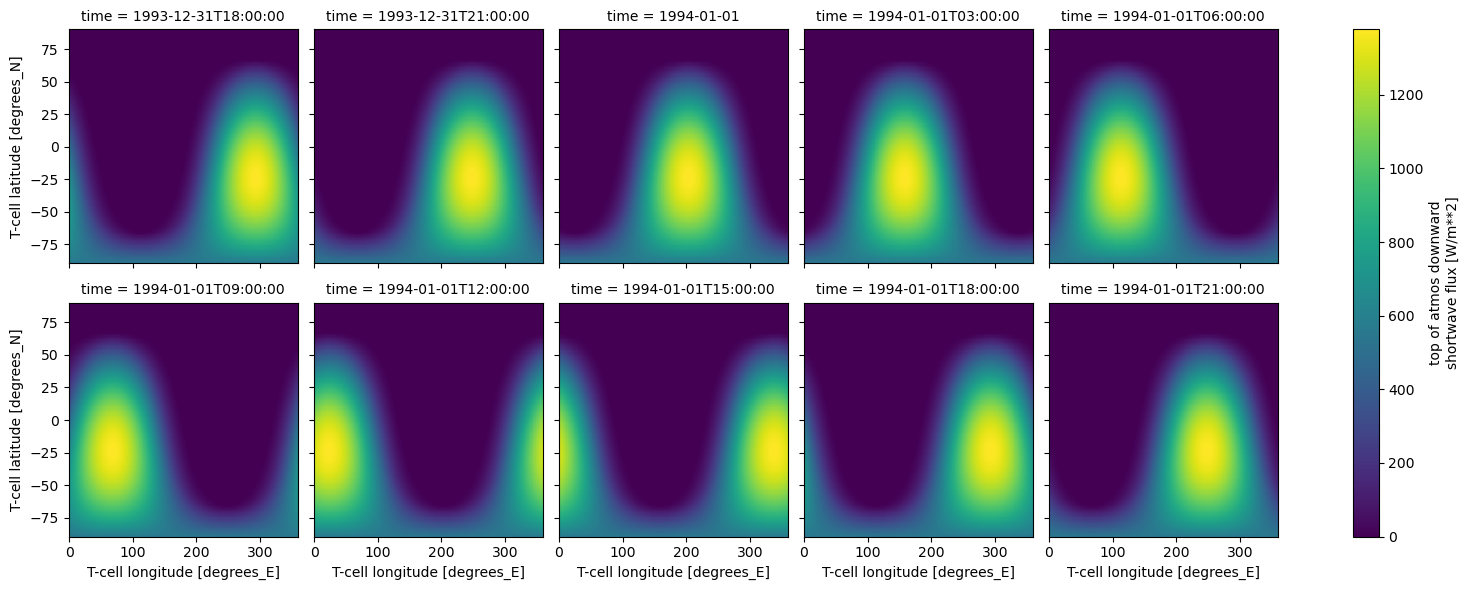

In [55]:
sw.plot(col="time", col_wrap=5)